# Generating Audio Illusions with Diffusion Models
Aileen Mi,
Valli Nachiappan,
Manisha Pillai

# Notes
- When we finish, move notebook to repo https://github.com/beepo34/cs280-final-proj

In [ ]:
! pip install -q diffusers accelerate huggingface_hub torchsde soundfile einops

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 49.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 34.9 MB/s eta 0:00:00


# Experiments
- Auffusion (audio model)
- HiFi-GAN (vocoder), Griffin-Lim algorithm (for spectrogram -> audio synthesis)


In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from einops import rearrange
from huggingface_hub import snapshot_download, notebook_login
from diffusers import StableDiffusionPipeline, DDIMScheduler, CosineDPMSolverMultistepScheduler
import soundfile as sf
from IPython.display import display, Audio
from tqdm import tqdm
from functools import partial
tqdm = partial(tqdm, position=0, leave=True)

## Auffusion

In [ ]:
# navigate to directory containing converter.py file
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# replace with your local path
%cd /content/drive/MyDrive/finalproject
# %cd /content/drive/MyDrive/Berkeley

/content/drive/MyDrive/finalproject


In [ ]:
from converter import Generator, denormalize_spectrogram

In [ ]:
pretrained_model_audio = "auffusion/auffusion-full-no-adapter"
dtype = torch.float16
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# download model
if not os.path.isdir(pretrained_model_audio):
    pretrained_model_audio = snapshot_download(pretrained_model_audio)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 17 files:   0%|          | 0/17 [00:00<?, ?it/s]

pytorch_model.bin:   0%|          | 0.00/492M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.05k [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/518 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/374 [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/492 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/335M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.86k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/577 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

vocoder.pt:   0%|          | 0.00/54.8M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

In [ ]:
vocoder = Generator.from_pretrained(pretrained_model_audio, subfolder="vocoder")
vocoder = vocoder.to(device=device, dtype=dtype)

/usr/local/lib/python3.11/dist-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


In [ ]:
pipe = StableDiffusionPipeline.from_pretrained(pretrained_model_audio, torch_dtype=dtype)
pipe = pipe.to(device)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--auffusion--auffusion-full-no-adapter/snapshots/a75ebf2e22d76f8b3cdafcd2a42fd4abba43f7ec/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--auffusion--auffusion-full-no-adapter/snapshots/a75ebf2e22d76f8b3cdafcd2a42fd4abba43f7ec/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--auffusion--auffusion-full-no-adapter/snapshots/a75ebf2e22d76f8b3cdafcd2a42fd4abba43f7ec/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--auffusion--auffusion-full-no-adapter/snapshots/a75ebf2e22d76f8b3cdafcd2a42fd4abba43f7ec/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
The config attributes {'decay': 0.9999, 'inv_gamma': 1.0, 'min_decay':

In [ ]:
vae = pipe.vae
tokenizer = pipe.tokenizer
text_encoder = pipe.text_encoder
unet = pipe.unet

In [ ]:
scheduler = DDIMScheduler.from_pretrained(pretrained_model_audio, subfolder="scheduler")

### Audio Generation Example
- code adapted from https://colab.research.google.com/drive/1JEPHT_AvHZxvlaZAsetkBnMrzCGMRKaf?usp=sharing#scrollTo=mlxyx3eC_i3m

  0%|          | 0/100 [00:00<?, ?it/s]

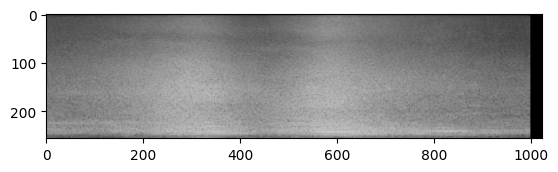

In [ ]:
prompt = "a car is passing by"
seed = 42

generator = torch.Generator(device=device).manual_seed(seed)

with torch.autocast("cuda"):
    output_spec = pipe(
        prompt=prompt, num_inference_steps=100, generator=generator, height=256, width=1024, output_type="pt"
    ).images[0]

matplotlib.pyplot.imshow(output_spec.cpu().permute(1, 2, 0).numpy().astype('float32'))

denorm_spec = denormalize_spectrogram(output_spec)
denorm_spec_audio = vocoder.inference(denorm_spec)

display(Audio(denorm_spec_audio, rate=16000))

### CFG
- code adapted from https://github.com/IFICL/images-that-sound

In [ ]:
class Identity():
    def __init__(self):
        pass

    def view(self, im):
        return im

    def inverse_view(self, noise):
        return noise

    def transform_spec(self, spec):
        return spec

class Reverse():
    def __init__(self):
        pass

    def view(self, im):
        return torch.flip(im, [3])

    def inverse_view(self, noise):
        return torch.flip(noise, [3])

    def transform_spec(self, spec):
        return torch.flip(spec, [2])

class Flip():
    def __init__(self):
        pass

    def view(self, im):
        return torch.flip(im, [2])

    def inverse_view(self, noise):
        return torch.flip(noise, [2])

    def transform_spec(self, spec):
        return torch.flip(spec, [1])

class Negate():
    def __init__(self):
        pass

    def view(self, im):
        return 1 - im

    def inverse_view(self, noise):
        return 1 - noise

    def transform_spec(self, spec):
        return 1 - spec

class Patch():
    def __init__(self, num_patches=8):
        assert 128 % num_patches == 0, "`num_patches` must divide image width of latents"

        self.num_patches = num_patches

        # Generate permutation
        self.perm = torch.randperm(self.num_patches)

        # Compute inverse permutation inline
        self.perm_inv = torch.empty_like(self.perm)
        self.perm_inv[self.perm] = torch.arange(len(self.perm))

    def view(self, im):
        # x shape: (C, H, W) or (B, C, H, W)
        is_batched = im.dim() == 4

        if is_batched:
            B, C, H, W = im.shape
        else:
            C, H, W = im.shape

        patch_width = W // self.num_patches

        # Reshape into horizontal patches
        if is_batched:
            patches = rearrange(im, 'b c h (n pw) -> b n c h pw', n=self.num_patches, pw=patch_width)
            patches = patches[:, self.perm]
            x_perm = rearrange(patches, 'b n c h pw -> b c h (n pw)')
        else:
            patches = rearrange(im, 'c h (n pw) -> n c h pw', n=self.num_patches, pw=patch_width)
            patches = patches[self.perm]
            x_perm = rearrange(patches, 'n c h pw -> c h (n pw)')

        return x_perm

    def inverse_view(self, noise):
        # x shape: (C, H, W) or (B, C, H, W)
        is_batched = noise.dim() == 4

        if is_batched:
            B, C, H, W = noise.shape
        else:
            C, H, W = noise.shape

        patch_width = W // self.num_patches

        # Reshape into horizontal patches
        if is_batched:
            patches = rearrange(noise, 'b c h (n pw) -> b n c h pw', n=self.num_patches, pw=patch_width)
            patches = patches[:, self.perm_inv]
            x_inv = rearrange(patches, 'b n c h pw -> b c h (n pw)')
        else:
            patches = rearrange(noise, 'c h (n pw) -> n c h pw', n=self.num_patches, pw=patch_width)
            patches = patches[self.perm_inv]
            x_inv = rearrange(patches, 'n c h pw -> c h (n pw)')

        return x_inv

    def transform_spec(self, spec):
        assert spec.shape[-2:] == (256, 1024), "Expected spec of shape (c, 256, 1024)"
        patch_width = 1024 // self.num_patches

        patches = rearrange(spec, 'c h (n pw) -> n c h pw', n=self.num_patches, pw=patch_width)
        patches = patches[self.perm]
        spec_perm = rearrange(patches, 'n c h pw -> c h (n pw)')

        return spec_perm

In [ ]:
@torch.no_grad()
def get_text_embeds(prompt: str):
    input = tokenizer([prompt], padding="max_length", max_length=tokenizer.model_max_length, return_tensors='pt')
    embeds = text_encoder(input.input_ids.to(device))[0]
    return embeds

@torch.no_grad()
def estimate_noise(t, latents, embeds, guidance_scale=7.5):
    # expand latents for classifier-free guidance
    latent_model_input = torch.cat([latents] * 2)

    # predict noise residual
    noise_pred = unet(latent_model_input, t, encoder_hidden_states=embeds)['sample']

    # perform guidance
    noise_pred_uncond, noise_pred_cond = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_cond - noise_pred_uncond)
    return noise_pred

@torch.no_grad()
def decode_latents(latents):
    latents = 1 / vae.config.scaling_factor * latents
    image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    return image

In [ ]:
# main denoise code
def denoise_transform(prompt_1, prompt_2, transform_1, transform_2, neg_1='', neg_2='', seed=42, weight=0.5):
    generator = torch.Generator(device=device).manual_seed(seed)

    # get text embeddings
    cond_embed_1 = get_text_embeds(prompt_1)
    uncond_embed_1 = get_text_embeds(neg_1)
    embed_1 = torch.cat([uncond_embed_1, cond_embed_1], dim=0)

    cond_embed_2 = get_text_embeds(prompt_2)
    uncond_embed_2 = get_text_embeds(neg_2)
    embed_2 = torch.cat([uncond_embed_2, cond_embed_2], dim=0)

    scheduler.set_timesteps(100)

    # initialize random latents
    latents = torch.randn((embed_1.shape[0] // 2, unet.config.in_channels, 256 // 8, 1024 // 8), generator=generator, dtype=dtype, device=device)
    latents = latents * scheduler.init_noise_sigma

    # denoising
    for t in tqdm(scheduler.timesteps, desc=f"denoising"):
        transformed_latents_1 = transform_1.view(latents)
        noise_1 = estimate_noise(t, transformed_latents_1, embed_1)
        noise_1 = transform_1.inverse_view(noise_1)

        transformed_latents_2 = transform_2.view(latents)
        noise_2 = estimate_noise(t, transformed_latents_2, embed_2)
        noise_2 = transform_2.inverse_view(noise_2)

        # average noise
        noise = weight * noise_1 + (1 - weight) * noise_2

        latents = scheduler.step(noise, t, latents)['prev_sample']

    spec = decode_latents(latents).squeeze(0)

    spec_1 = transform_1.transform_spec(spec)

    matplotlib.pyplot.imshow(spec_1.cpu().permute(1, 2, 0).numpy().astype('float32'))
    matplotlib.pyplot.show()

    denorm_spec = denormalize_spectrogram(spec_1)
    audio = vocoder.inference(denorm_spec)

    display(Audio(audio, rate=16000))

    # display flipped audio
    spec_2 = transform_2.transform_spec(spec)

    matplotlib.pyplot.imshow(spec_2.cpu().permute(1, 2, 0).numpy().astype('float32'))
    matplotlib.pyplot.show()

    flipped_denorm_spec = denormalize_spectrogram(spec_2)
    flipped_audio = vocoder.inference(flipped_denorm_spec)

    display(Audio(flipped_audio, rate=16000))

    return spec_1, spec_2

### Results

denoising: 100%|██████████| 100/100 [00:31<00:00,  3.18it/s]


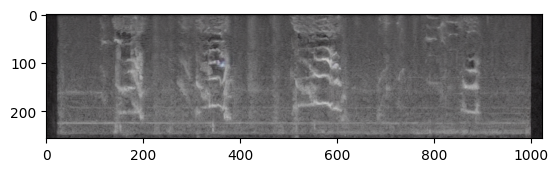

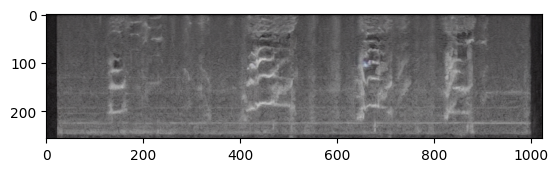

In [ ]:
dog_spec, cat_spec = denoise_transform("a dog whining", "a cat meowing", Identity(), Reverse())

denoising: 100%|██████████| 100/100 [00:29<00:00,  3.38it/s]


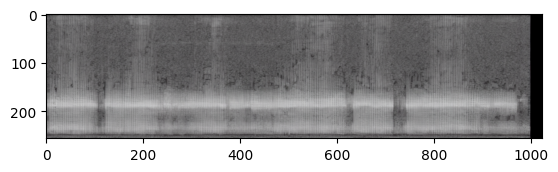

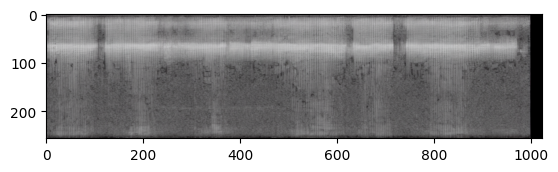

In [ ]:
spec_1, spec_2 = denoise_transform("a cat purring", "a cricket chirping", Identity(), Flip(), seed=154354)

denoising: 100%|██████████| 100/100 [00:31<00:00,  3.16it/s]


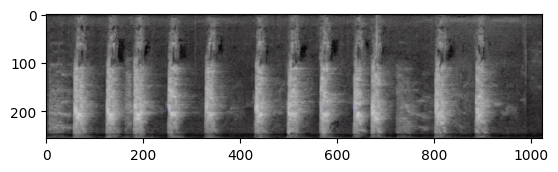

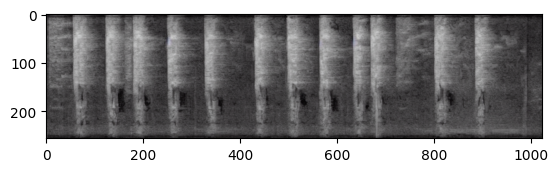

In [ ]:
spec_1, spec_2 = denoise_transform("a dog barking", "a bird squawking", Identity(), Flip(), seed=154354)